In [2]:

%load_ext autoreload
%autoreload 2
%matplotlib inline

import copy
import torch
import torch.nn as nn
import torchvision.transforms.functional as T
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier

from pretrain import init, train
from configs import FCConfig, CAEConfig, MAEConfig
from src.data.collators import fc_collator
from src.utils.utils import set_random_seed

from src.model.FullyConnectedAE import FCAutoencoder
from src.model.ConvolutionalAE import CNNAutoencoder
from src.model.mae.MAE import MAE

from src.data.dataset import get_train_dataset, get_val_dataset
from train import init_classifier, train_classifier

plt.rcParams['font.size'] = 20

In [1]:
import os
os.chdir("/home/idpeshekhonov/AE")

In [3]:
RANDOM_STATE = 322
set_random_seed(RANDOM_STATE)

### Setting up some useful functions

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"


def draw_pretrain_plot(train_losses, val_losses):
    x = np.arange(len(train_losses))

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_losses, c="C0", label="train")
    plt.plot(x, val_losses, c="C1", label="val")
    plt.title("Pretrain model losses")
    plt.xlabel("Epoches")
    plt.ylabel("Loss")
    plt.semilogy()
    plt.legend()

@torch.no_grad()
def construct_grid(model, dataset, num_images=10, ids=None, f=None, collator=None, mae=False):
    if ids is None:
        ids = np.random.randint(0, len(dataset), size=num_images)
    img_batch = torch.Tensor().to(device)
    restored_img_batch = torch.Tensor().to(device)
    masked_batch = torch.Tensor().to(device)
    for idx in ids:
        img, _ = dataset[idx]
        if collator is not None:
            img, _ = collator([(img, _)])
        else:
            img = img.unsqueeze(0)
        img = img.to(device, non_blocking=True)
        restored_img = model(img)
        if mae:
            restored_img, mask = restored_img
            restored_img = restored_img * mask + img * (1 - mask)
            masked_batch = torch.cat([masked_batch, img * (1 - mask)], dim=0)
        if f is not None:
            img = f(img)
            restored_img = f(restored_img)
        img_batch = torch.cat([img_batch, img], dim=0)
        restored_img_batch = torch.cat([restored_img_batch,
                                        restored_img], dim=0)

    img_batch = make_grid(img_batch.cpu(), nrow=num_images, padding=1, normalize=True, value_range=(-1, 1))
    restored_img_batch = make_grid(restored_img_batch.cpu(), nrow=num_images, padding=1, normalize=True, value_range=(-1, 1))
    if mae:
        masked_batch = make_grid(masked_batch.cpu(), nrow=num_images, padding=1, normalize=True, value_range=(-1, 1))
        grid = torch.cat([img_batch, masked_batch, restored_img_batch], dim=1)
    else:
        grid = torch.cat([img_batch, restored_img_batch], dim=1)
    return grid

def show_grid(grid, img_size=(5, 5)):
    fig, axs = plt.subplots(figsize=(5 * img_size[0], 5 * img_size[1]),
                            squeeze=False)
    grid = grid.detach()
    grid = T.to_pil_image(grid)
    axs[0, 0].imshow(grid)
    axs[0, 0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

def pretrain(model, optimizer, criterion, scheduler, train_dataloader,
             val_dataloader, val_dataset, num_epoches, checkpoint_path, f=None, collator=None,
             mae=False):
    train_losses = []
    val_losses = []
    for epoch in range(num_epoches):
        train_loss, val_loss = train(model, optimizer, criterion, scheduler,
                                     train_dataloader, val_dataloader, checkpoint_path,
                                     device=device, num_epoches=1)
        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())

        clear_output()
        draw_pretrain_plot(train_losses, val_losses)
        grid = construct_grid(model, val_dataset, f=f, collator=collator, mae=mae)
        show_grid(grid)
        plt.show()

def experiment(config, model_constructor, img_reshaper=None, data_collator=None,
               mae=False):
    model, optimizer, criterion, scheduler = init(config, model_constructor)
    model.to(device)

    train_dataset = get_train_dataset("/home/idpeshekhonov/AE/data", False)
    val_dataset = get_val_dataset("/home/idpeshekhonov/AE/data", False)
    train_dataloader = DataLoader(train_dataset, config.train_config.train_batch_size, shuffle=True,
                                  num_workers=6, collate_fn=data_collator, pin_memory=True, drop_last=True)
    val_dataloader = DataLoader(val_dataset, config.train_config.eval_batch_size, shuffle=False,
                                num_workers=6, collate_fn=data_collator, pin_memory=True)


    pretrain(model, optimizer, criterion, scheduler, train_dataloader, val_dataloader,
             val_dataset, config.train_config.num_epoches,
             config.train_config.checkpoint_path, img_reshaper, data_collator, mae=mae)
    return model

In [5]:
neighbours_set = np.linspace(5, 100, 10).astype(np.int32)

def find_hyperparam(X_train, y_train):
    folds = 10
    kf = KFold(n_splits=folds, random_state=RANDOM_STATE, shuffle=True)
    acc = []
    for neighbours in neighbours_set:
        acc.append(0)
        for train_index, test_index in kf.split(X_train):
            X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
            y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]
            model = KNeighborsClassifier(n_neighbors=neighbours, n_jobs=8).fit(X_train_cv, y_train_cv)
            y_pred = model.predict(X_test_cv)
            y_pred = torch.tensor(y_pred, device=y_test_cv.device)
            acc[-1] += torch.mean((y_test_cv == y_pred).float())
        acc[-1] /= folds

    return neighbours_set[np.array(acc).argmax()]

def knn_based_accuracy(X_train, y_train, n_neighbours):
    folds = 5
    kf = KFold(n_splits=folds, random_state=RANDOM_STATE, shuffle=True)
    acc = []
    for train_index, test_index in kf.split(X_train):
        X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
        y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]
        model = KNeighborsClassifier(n_neighbors=n_neighbours, n_jobs=8).fit(X_train_cv, y_train_cv)
        y_pred = model.predict(X_test_cv)
        y_pred = torch.tensor(y_pred, device=y_test_cv.device)
        acc.append(torch.mean((y_test_cv == y_pred).float()).item())

    return np.mean(acc)

In [6]:
def train_plots(val_losses, val_accs):
    x = np.arange(len(val_losses))
    fig, ax = plt.subplots(1, 2, figsize=(17, 7))
    ax[0].set(title="Validation NLL loss", xlabel="Epoches", ylabel="NLL loss")
    ax[1].set(title="Classifier accuracy", xlabel="Epoches", ylabel="Accuracy")

    ax[0].plot(x, val_losses, c="C1")
    ax[1].plot(x, val_accs, c="C1")
    ax[0].semilogy()


def classifier_train(model, optimizer, criterion, scheduler, train_dataloader,
                     val_dataloader, num_epoches, checkpoint_path):
    val_losses = []
    val_accs = []
    for epoch in range(num_epoches):
        val_loss, val_acc = train_classifier(model, optimizer, criterion, scheduler,
                                             train_dataloader, val_dataloader, checkpoint_path,
                                             device=device, num_epoches=1)
        val_losses.append(val_loss[-1].item())
        val_accs.append(val_acc[-1].item())

        clear_output()
        train_plots(val_losses, val_accs)
        plt.show()

    return val_losses, val_accs


def classifier_experiment(config, model_constructor, pretrained_path=None, mode="fine_tune", freeze=False,
                          num_epoches=10, data_collator=None, mae=False):
    model, _, _, scheduler = init(config, model_constructor)
    if pretrained_path is not None:
        model.load_state_dict(torch.load(pretrained_path)["model"])
    model = init_classifier(model.encoder, config, mode, freeze, mae=mae).to(device)
    # print(model)

    train_dataset = get_train_dataset("/home/idpeshekhonov/AE/data", False)
    val_dataset = get_val_dataset("/home/idpeshekhonov/AE/data", False)
    train_dataloader = DataLoader(train_dataset, config.train_config.train_batch_size, shuffle=True,
                                  num_workers=6, collate_fn=data_collator, pin_memory=True, drop_last=True)
    val_dataloader = DataLoader(val_dataset, config.train_config.eval_batch_size, shuffle=False,
                                num_workers=6, collate_fn=data_collator, pin_memory=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5 if not freeze else 3e-4)
    criterion = nn.NLLLoss()
    scheduler = scheduler if not freeze else None

    return classifier_train(model, optimizer, criterion, scheduler, train_dataloader, val_dataloader,
                            num_epoches, config.train_config.checkpoint_path)


def multiaproach_experiment(config, constructor, chechpoint_path, num_epoches=10, data_collator=None, mae=False):
    results = []
    # results.append(
    #     classifier_experiment(config, constructor, num_epoches=num_epoches, data_collator=data_collator, mae=mae)
    # )  #no pretrain results
    results.append(
        classifier_experiment(config, constructor, pretrained_path=chechpoint_path, mode="fine_tune",
                              freeze=False, num_epoches=num_epoches, data_collator=data_collator, mae=mae)
    )
    results.append(
        classifier_experiment(config, constructor, pretrained_path=chechpoint_path, mode="fine_tune",
                              freeze=True, num_epoches=num_epoches, data_collator=data_collator, mae=mae)
    )
    results.append(
        classifier_experiment(config, constructor, pretrained_path=chechpoint_path, mode="probing",
                              freeze=False, num_epoches=num_epoches, data_collator=data_collator, mae=mae)
    )
    results.append(
        classifier_experiment(config, constructor, pretrained_path=chechpoint_path, mode="probing",
                              freeze=True, num_epoches=num_epoches, data_collator=data_collator, mae=mae)
    )

    clear_output()
    x = np.arange(num_epoches)
    f, ax = plt.subplots(1, 2, figsize=(20, 7))
    ax[0].set(title="Loss compare", xlabel="Epoches", ylabel="NLL loss")
    ax[1].set(title="Accuracy compare", xlabel="Epoches", ylabel="Accuracy")
    labels = [
        "No pretrain", "Model tune with classifier", "Train only classifier",
        "Model tune with probing", "Train only probing"
    ]
    for i in range(5):
        for j in range(2):
            ax[j].plot(x, results[i][j], c=f"C{i}", label=labels[i])
    ax[0].legend()
    ax[0].semilogy()
    ax[1].legend()
    plt.show()

    print("No pretrain:", np.max(results[0][1]))
    print("Ft:", np.max(results[1][1]))
    print("Ft + freeze:", np.max(results[2][1]))
    print("Probing:", np.max(results[3][1]))
    print("Probing + freeze:", np.max(results[4][1]))


### Pretraining

In [ ]:
config = MAEConfig
constructor = MAE
experiment(config, constructor, mae=True)

epoch loss: 0.4716271162033081:  79%|███████▉  | 309/390 [00:38<00:08,  9.18it/s] 

In [ ]:
model = MAE(32, 2, 3, 768, 192, .75, 8, 3, 4, 3)
model.load_state_dict(torch.load("checkpoints/mae/final.pth")["model"])
val_dataset = get_val_dataset("/home/idpeshekhonov/AE/data", False)

grid = construct_grid(model, val_dataset, mae=True)
show_grid(grid)

### Training

IndexError: list index out of range

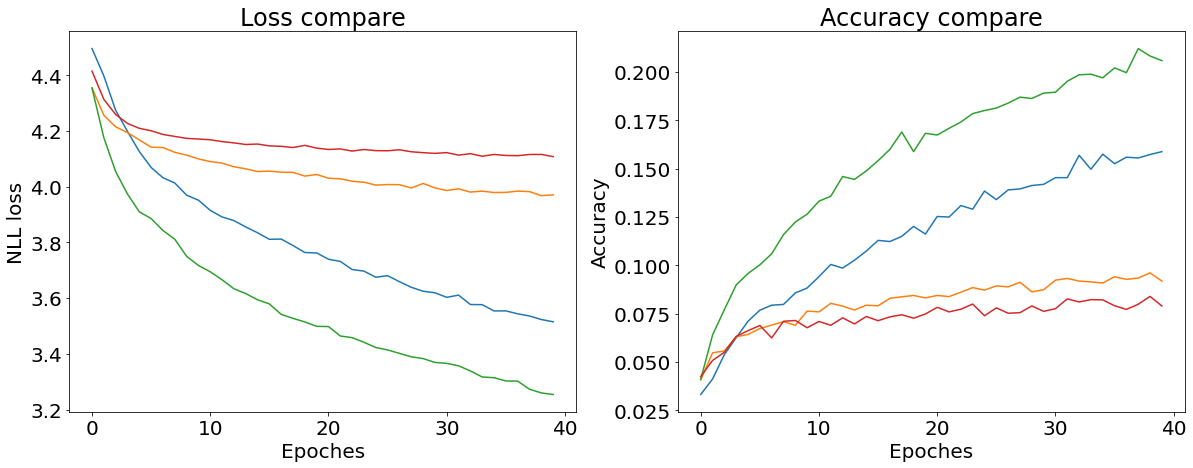

In [7]:
config = MAEConfig
constructor = MAE
num_epoches = 40
path = "checkpoints/mae/final.pth"

multiaproach_experiment(config, constructor, path, num_epoches, mae=True)

On the plot above 
    * `blue` line is `smart classifier + fine tune`
    * `yellow` line is `only classifier`
    * `green` line is `linear classifier + fine tune`
    * `red` line is 